In [1]:
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__

from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *


from src.seqsDataLoader_fix import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

from src.models.C_VITAE import C_VITAE
from src.models.DeepSequence import DeepSequence
from src.models.encoder_decoder import get_encoder, get_decoder


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import argparse; import sys; sys.argv=['']; del sys

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    
    
    paths.add_argument('--path_orig', type=str, default="../data/BLAT20.2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/alignedBLAT20.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    
    gpsetup.add_argument('--Task', type=int, default = 5, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = [1.0, 0.0, 0.0, 0.0, 0.0], help='multitaks-gp initialization') 
    #[1e-6,1e-5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-6,1e-5], help='noise constrain') #
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=1280, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=1280, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings 8
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=14, help='dimensionality of the latent space') #5, 10
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [ ]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

gp_params = std.get_config_vals(['noise_constraint',
                                 'Task',
                                 'interpolation_type',
                                 'Option',
                                 'Lengthscale',
                                 'Initialization'])

alphabets = ['?', '-', 'A', 'D', 'L'] #-> for 4 sequences
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_Toy_22_march2024.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_Toy_29_march2024.pth'

#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_Toy_17_Aug2024.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_Toy_30_Aug2024.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_Toy_5_Sept2024.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_Toy_11_June2025.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_Toy_16_June2025.pth'



print('Ok')

None
Ok


In [5]:
#from src.gp_cpab.src.extra import experiment_utilities
#from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, 
                                alphabet = alphabets, 
                                enable_variable_length=True, 
                                device=device)

dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, 
                                        alphabet = alphabets, 
                                        enable_variable_length=True, 
                                        device=device)

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

trainloader, testloader = Sequence_Data_Loader(dataset_msa, 
                                               dataset_test=None, batch_size=batches)

trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, 
                                                                     dataset_test=None, 
                                                                     batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

Ok
Ok
Loading data


/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader_fix.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading Deformation Model...
Loaded


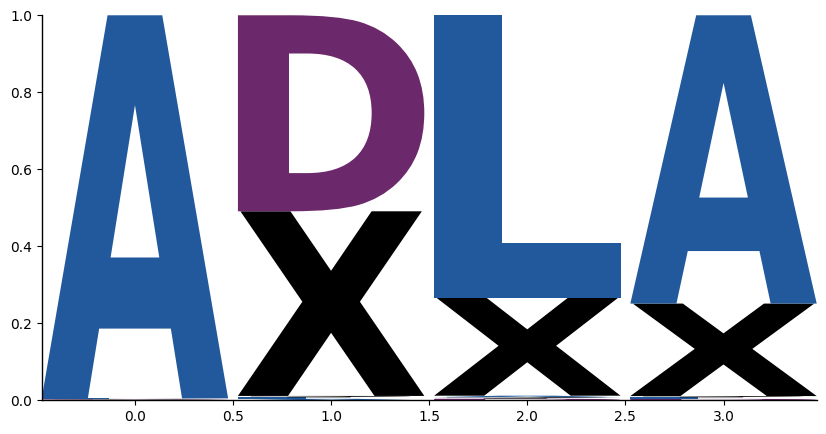

In [ ]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, 
                       alphabets, device = device, 
                       #outputnonlin=torch.nn.ReLU())
                       outputnonlin=torch.nn.LeakyReLU(0.01))

optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr*0.01)#, weight_decay=1e-5)#*0.01)

loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

#import ipdb; ipdb.set_trace()
if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
else:
    deepseq.training_representation(trainloader_pretrainer, 
                                    optimizer_deepseq, 
                                    args.n_epochs*7, 
                                    warmup=1, 
                                    logdir=logdir, 
                                    out_modelname=outmodel_name)
    #args.n_epochs*2

#import ipdb; ipdb.set_trace()
deepseq(dataset_msa.prot_space)
plot_logos_probs(torch.nn.functional.softmax(deepseq(dataset_msa.prot_space)[0].cpu(), dim=-1), alphabets)
#plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)



In [ ]:
import time
import copy

def fit_VITAE_with_pretrained_DeepSeq(trainloader, 
                                      optimizer, 
                                      model, 
                                      DS, 
                                      n_epochs=10, 
                                      warmup=1, 
                                      logdir='',
                                      testloader=None, 
                                      eq_samples=1, 
                                      iw_samples=1, 
                                      beta=1.0, 
                                      eval_epoch=10000,
                                       **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """
        # Chunk to get the best checkpoint at least for this
        # experiment, since the amount of data point is very law
        #import ipdb; ipdb.set_trace()
        best_fit = 1e6; best_epoch = 0
        best_model = model

        model.train()
        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        


        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()
                #import ipdb;ipdb.set_trace()
                # Feed forward data
                data = data.to(torch.float32).to(casted_device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                
                loss = model.get_elbo(data, out, beta=0.5e-3).mean()#0.5e-3).mean()
                
                # Backpropegate and optimize
                loss.backward()
                optimizer.step()
                
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': loss.item()})

                if loss < best_fit:
                    best_fit = loss
                    best_model.load_state_dict( copy.deepcopy( model.state_dict() ) )
                    best_epoch = epoch
                
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)

        #import ipdb; ipdb.set_trace()
        print(f'best fit: {best_fit} \n best epoch: {best_epoch} \n\n Model: {best_model}')
        model.load_state_dict( copy.deepcopy( best_model.state_dict() ) )
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [ ]:

batch_loss_dict = {}
logdir_density = 'pretrained_densities'


#outmodel_name_density = 'trained_density_toy_4_preprint_19June2025.pth'
outmodel_name_density = 'trained_density_toy_4_preprint_9Jule2025_FAST_2.pth'
#

pretrained_density = logdir_density + "/" + outmodel_name_density
import os


# posterior variance attribute is to enabled whether to speed up the calculations or to 
# leave it in order to see the components from MOGPs in the diffeomorphic transformation 
# posterior_variance = False -> leave the posterior variance for seeing the components with uncertainty
# posterior_variance = True -> skip the posterior variance

model = C_VITAE(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    posterior_variance = False,
                    trans_parameters = ( [window_grid], device, gp_params ) )

#model.get_deepsequence_module(deepseq)

# Optimizer
#opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5) 
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5) 

model_name = '/trained_model_softmax.pt'

if os.path.isfile(pretrained_density):
    print ("Loading Density Model...")
    model.load_state_dict( torch.load(pretrained_density, map_location=casted_device) )
    print ("Loaded")
else:
    fit_VITAE_with_pretrained_DeepSeq(trainloader, 
                                      opt, 
                                      model, 
                                      deepseq, 
                                      n_epochs=500, 
                                      warmup=1, 
                                      logdir='',
                                      testloader=None, 
                                      eq_samples=1, 
                                      iw_samples=1, beta=1.0, eval_epoch=10) # initi
    
    torch.save(model.state_dict(), pretrained_density)

No CUDA runtime is found, using CUDA_HOME='/home/kvr226/miniconda3/envs/PGM_latent_alignment'
> /home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/transformer.py(27)<module>()
     26 import ipdb; ipdb.set_trace()
---> 27 _dir = get_dir(__file__)
     28 _verbose = False # TODO: set this flag in the main class, maybe


Program interrupted. (Use 'cont' to resume).
> /home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/file_baton.py(41)wait()
     40         '''
---> 41         while os.path.exists(self.lock_file_path):
     42             time.sleep(self.wait_seconds)

Loading Density Model...
Loaded


/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


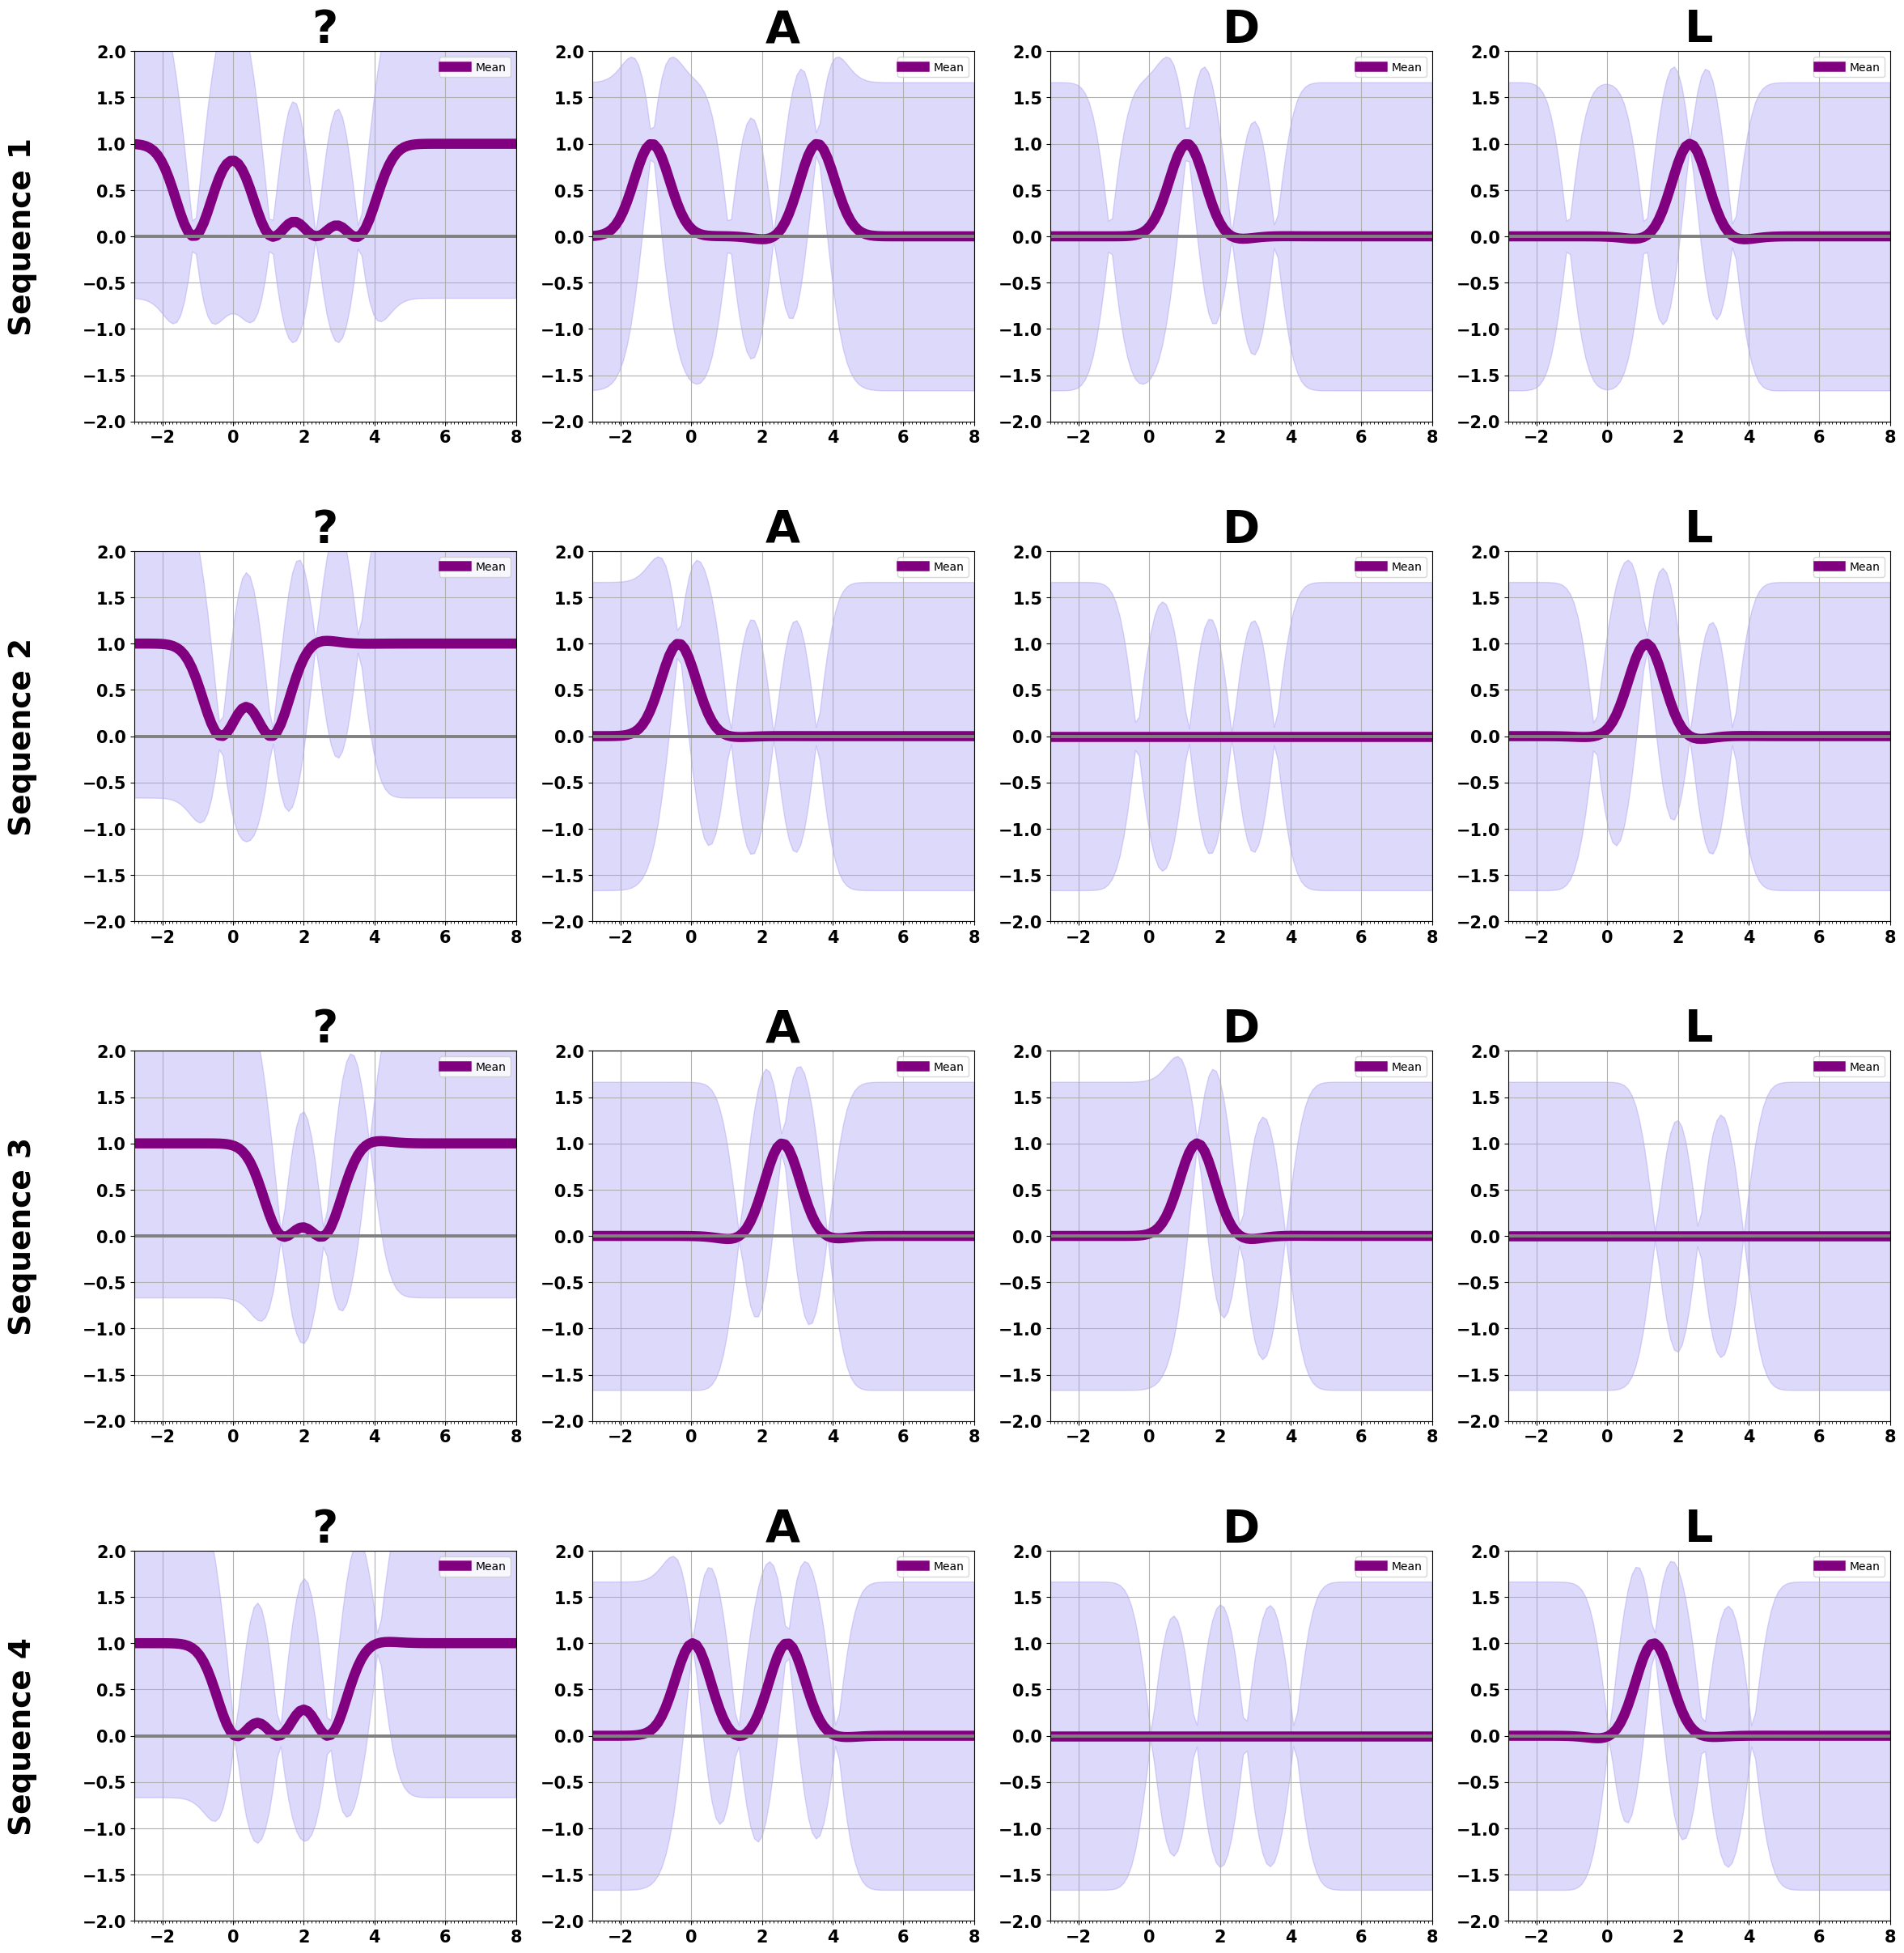

In [ ]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 

alphabets_GPcomps = ['?', 'A', 'D', 'L']
idx_GPcomps = [0,2,3,4]

def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    
    #import ipdb; ipdb.set_trace()
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)

    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # determine if the MOGP regressor for mapping the transformation is
    # into FAST mode or not in order to reshape the input

    #if 'fast' in str(type(batch_Multitask_model)):
    #    Ug = batch_Multitask_model._reformat_features(Ug.squeeze(1))

    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, 
                                                batch_Multitask_model, 
                                                batch_multitask_likelihood  )
    
    if 'fast' not in str(type(batch_Multitask_model)):
        trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
        lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
        upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'purple' ,linewidth=9.0)#blue
        axs.grid()
        axs.set_xlim(-0.1,4)
        axs.set_ylim(-2,2)
        if j%4==0:
            axs.set_ylabel(title, weight='bold',  fontsize=27, labelpad=40)
        

        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.25, color='mediumslateblue' )#color='#e6e6fa')#, edgecolor='purple',lw=0.3)# #ffb6c1
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )

        axs.axhline(0, color='grey', linewidth=2.8)
        axs.set_title(alphabets[j],  weight='bold',  fontsize=40)

        for tick in axs.get_xticklabels():
            tick.set_fontsize(15)
            tick.set_fontweight('bold')
        for tick in axs.get_yticklabels():
            tick.set_fontsize(15)
            tick.set_fontweight('bold')
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2, alph):

    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='Sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alph, title=title, fig = fig2)




def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize)#; fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    import ipdb; ipdb.set_trace()
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    #heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    #heatmap_from_tensor_tmp(backward.detach(). numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    #Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len*2)
    Ug=torch.linspace(-0.35,1,grid_length_for_GP).repeat(n_batch,1,1)*(seq_len*2)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(28,30)) #; fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    #figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(28,30))#; figdir.suptitle('Sequence Reconstruction', fontsize='large')
    fig.subplots_adjust(hspace=0.35)
    fig.subplots_adjust(hspace=0.35)

    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data[:,:,idx_GPcomps],
                                         lower[:,:,idx_GPcomps],upper[:,:,idx_GPcomps], fig, alphabets)
    #plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data[:,:,idx_GPcomps],
    #                                     lower_dir[:,:,idx_GPcomps],upper_dir[:,:,idx_GPcomps], figdir, alphabets)

# make the gp components into the transformation without including the gap token belonging to the pretrained model
#get_GP_behavior_from_model_alignment(trainloader.dataset.prot_space,model, deepseq, len_grid = 100, 
#                                     alphabets= alphabets_GPcomps )

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


Done
tensor([[[ 1.3880e-03,  0.0000e+00,  1.0002e+00, -1.8540e-03,  2.2468e-04],
         [ 5.5391e-03,  0.0000e+00, -2.4936e-02,  9.9783e-01,  2.1566e-02],
         [-1.4974e-03,  0.0000e+00,  1.0927e-02, -8.6094e-03,  9.9918e-01],
         [ 6.3965e-03,  0.0000e+00,  1.0005e+00,  9.6372e-04, -7.8279e-03]],

        [[ 6.7806e-02,  0.0000e+00,  9.3286e-01,  0.0000e+00, -6.7146e-04],
         [ 6.2427e-01,  0.0000e+00,  2.6599e-01,  0.0000e+00,  1.0975e-01],
         [ 4.6650e-03,  0.0000e+00,  4.3650e-04,  0.0000e+00,  9.9490e-01],
         [ 8.3624e-01,  0.0000e+00, -1.5699e-04,  0.0000e+00,  1.6391e-01]],

        [[ 9.3256e-02,  0.0000e+00,  9.7442e-01, -6.7671e-02,  0.0000e+00],
         [-3.7624e-02,  0.0000e+00,  6.0719e-02,  9.7691e-01,  0.0000e+00],
         [ 8.0338e-01,  0.0000e+00,  7.1433e-03,  1.8947e-01,  0.0000e+00],
         [ 1.4250e-01,  0.0000e+00,  8.5690e-01,  5.9183e-04,  0.0000e+00]],

        [[ 9.6810e-04,  0.0000e+00,  9.9914e-01,  0.0000e+00, -1.0841e-04],
 

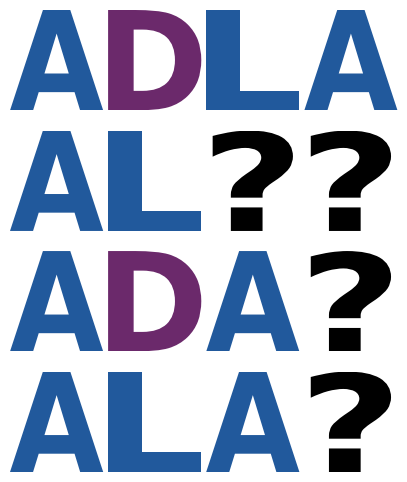

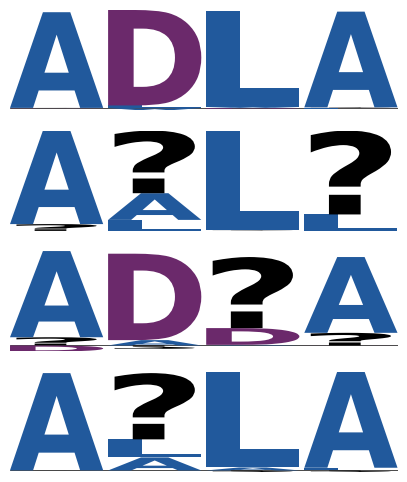

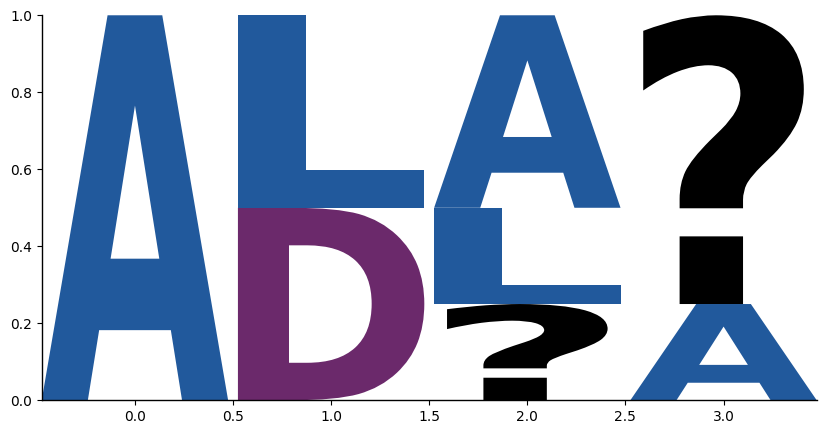

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



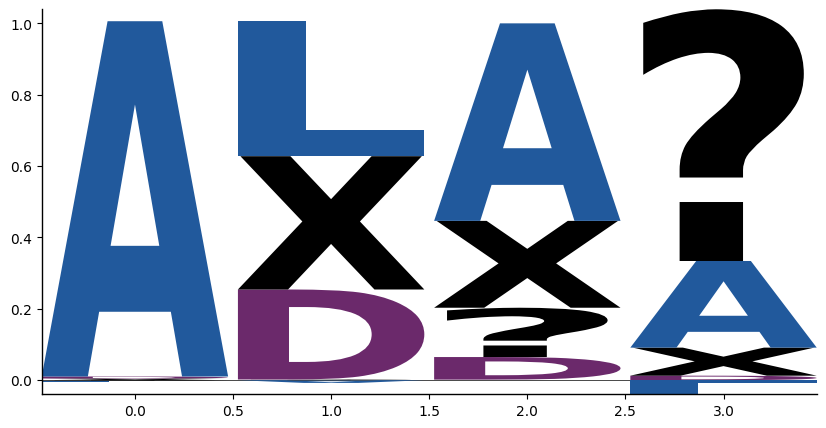

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



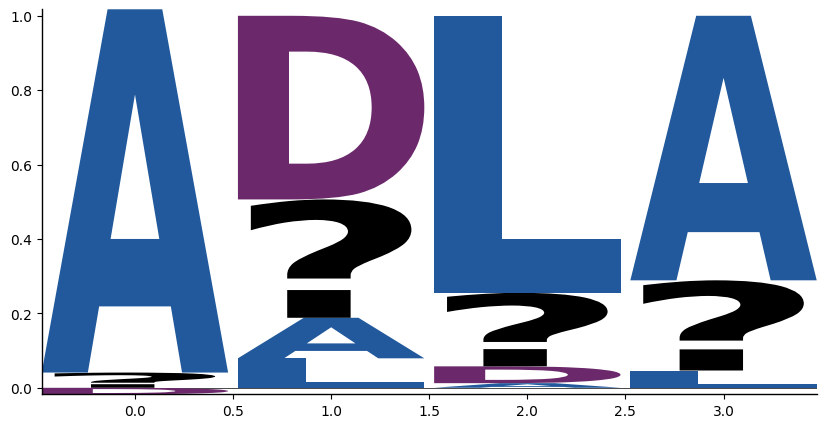

In [ ]:
model.eval()
import ipdb; ipdb.set_trace()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print( recon_data_train[5])
alignment = recon_data_train[5]

plot_msa_from_preds(trainloader.dataset.prot_space.cpu(), alphabets, figsize=(5,6), show_axis=False)
plot_msa_from_preds(alignment.cpu(), alphabets, figsize=(5,6), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
#plot_logos_probs( torch.nn.functional.softmax(recon_data_train[0], dim=-1), alphabets)
plot_logos_probs(recon_data_train[0].cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
#plot_logos_probs( torch.nn.functional.softmax(recon_data_train[5], dim=-1), alphabets)
plot_logos_probs(recon_data_train[5].cpu(), alphabets)

